### Import Libraries

In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd

In [ ]:
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
dataset_dir = 'acne_images/'

# Get the list of all entries in the directory
entries = os.listdir(dataset_dir)

# Filter out only the directories
folders = [entry for entry in entries if os.path.isdir(os.path.join(dataset_dir, entry))]

print(folders)

# Data Preparation for Acne Types

### 1. Conversion of Multi Class to Multi Label

In [4]:
multi_label_image_dir= 'acne_image_multi_label' 
os.makedirs(multi_label_image_dir, exist_ok=True)

In [5]:
# Define the labels as folder names
labels = ['comedones', 'cysts', 'nodules', 'papules', 'pustules']

# Create a dictionary to hold the image names and their associated label binary indicators
image_labels = {}

# Iterate over each label (folder)
for label in labels:
    folder_path = os.path.join(dataset_dir, label)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        continue
    
    # Get the list of images in the current folder
    images = os.listdir(folder_path)
    
    # Iterate over each image
    for image in images:
        image_path = os.path.join(folder_path, image)
        
        # Ensure it's a file (and not a directory)
        if os.path.isfile(image_path):
            # If the image is already in the dictionary, update the current label to 1
            if image in image_labels:
                image_labels[image][label] = 1
            else:
                # Otherwise, create a new entry for the image with all labels initialized to 0
                image_labels[image] = {lbl: 0 for lbl in labels}
                image_labels[image][label] = 1

# Convert the dictionary into a DataFrame
image_labels_df = pd.DataFrame([
    {"image_name": image, **label_dict}
    for image, label_dict in image_labels.items()
])

# Save the DataFrame to a CSV file
output_csv_path = os.path.join(multi_label_image_dir, 'image_labels.csv')
image_labels_df.to_csv(output_csv_path, index=False)

print(f"CSV file created: {output_csv_path}")

CSV file created: acne_image_multi_label\image_labels.csv


### Visualising Dataset Distribution for each label

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'acne_image_multi_label/image_labels.csv'
image_labels_df = pd.read_csv(csv_file_path)

# Count the number of images for each label
label_counts = image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

Label Counts:
 comedones    294
cysts        124
nodules      154
papules      377
pustules     370
dtype: int64


C:\Users\imree\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### ` 1. Bar Plot `

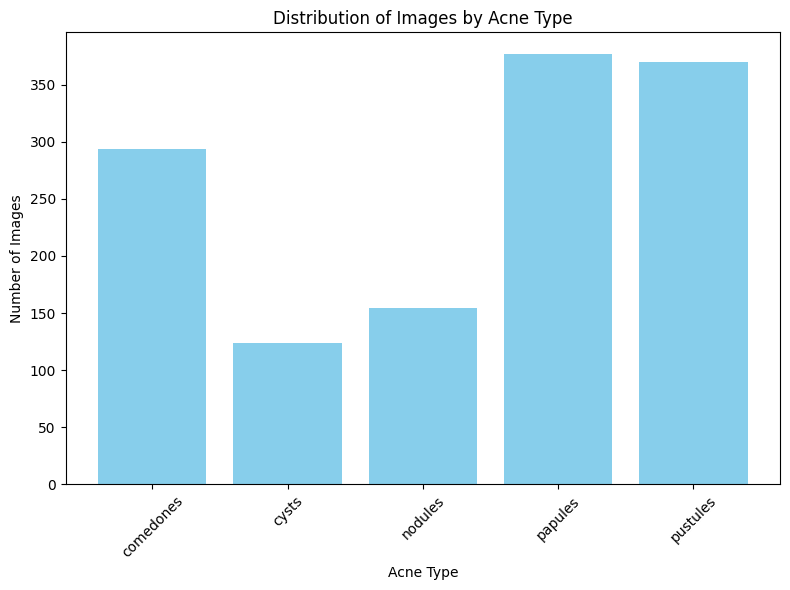

In [3]:
# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

### ` 2. Pie Chart`

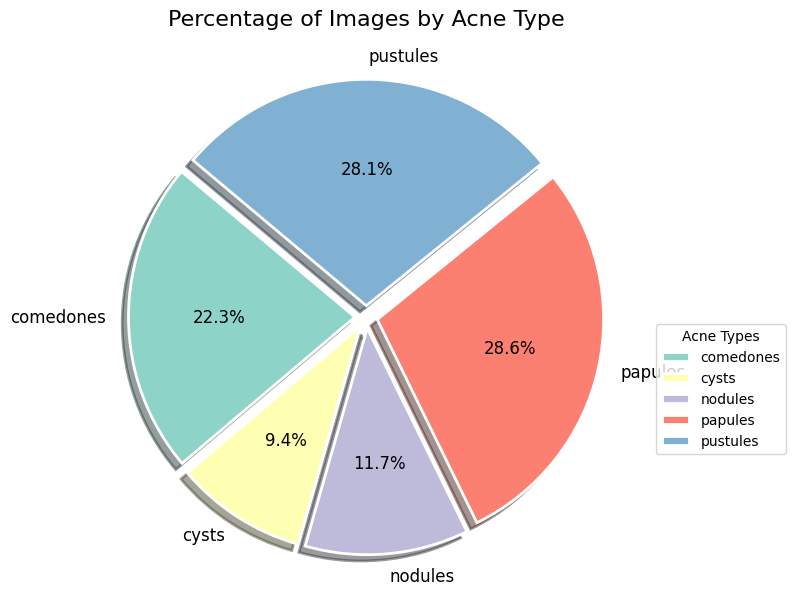

In [4]:
# Pie Chart
plt.figure(figsize=(8, 8))  # Make the figure square for the pie chart

# Explode the largest slice a bit for emphasis
explode = (0.05, 0.05, 0.05, 0.05, 0.05)  # Exploding all slices slightly for more visibility

# Create the pie chart
plt.pie(
    label_counts.values, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    explode=explode,  # Add explode effect
    shadow=True,  # Add shadow for depth
    colors=plt.cm.Set3.colors,  # Use a more vibrant color palette
    textprops={'fontsize': 12},  # Increase the font size of the percentages
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}  # Make the edges more distinct
)

# Add a title with a larger font size
plt.title('Percentage of Images by Acne Type', fontsize=16)

# Add a legend to the side of the chart
plt.legend(label_counts.index, title="Acne Types", loc="best", bbox_to_anchor=(1, 0.5))

# Display the pie chart
plt.tight_layout()
plt.show()

### Image Augmentation to enhance Dataset

`Based on the observations, it is evident that the dataset is highly imbalanced, with the 'cysts' and 'nodules' classes having significantly fewer images compared to the other three acne types. To address this imbalance, images exclusively belonging to the 'cysts' and 'nodules' categories were selected and augmented using various transformations. This augmentation was done to increase the number of images in these two classes, ensuring a more balanced dataset across all acne types.`

In [5]:
augmentation_dir = 'augmented_images/'  # Directory for storing augmented images
os.makedirs(augmentation_dir, exist_ok=True)

In [6]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import shutil  # To copy files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
dataset_dir = 'acne_images/'  # Original images folder
multi_image_labels_dir = 'acne_image_multi_label/'  # Combined images folder
augmentation_dir = 'augmented_images/'  # Directory for storing augmented images

# Ensure required directories exist
for dir_path in [multi_image_labels_dir, augmentation_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

# Define the labels as folder names
labels = ['comedones', 'cysts', 'nodules', 'papules', 'pustules']

# Step 1: Copy all images to 'multi_image_labels' folder
def copy_all_images_to_multi_label(source_dirs, dest_dir):
    for source_dir in source_dirs:
        for file_name in os.listdir(source_dir):
            source_file_path = os.path.join(source_dir, file_name)
            if os.path.isfile(source_file_path):
                dest_file_path = os.path.join(dest_dir, file_name)
                shutil.copy(source_file_path, dest_file_path)
                print(f"Copied {file_name} to {dest_dir}")

# Copy images from original folders to 'multi_image_labels' folder
image_folders = [os.path.join(dataset_dir, label) for label in labels]
copy_all_images_to_multi_label(image_folders, multi_image_labels_dir)

# Step 2: Load CSV file and augment selected images
image_labels_df = pd.read_csv('acne_image_multi_label/image_labels.csv')

# Identify images exclusively belonging to 'nodules' or 'cysts'
nodules_images = image_labels_df[
    (image_labels_df['nodules'] == 1) & 
    (image_labels_df['cysts'] == 0) & 
    (image_labels_df['comedones'] == 0) & 
    (image_labels_df['papules'] == 0) & 
    (image_labels_df['pustules'] == 0)
]

cysts_images = image_labels_df[
    (image_labels_df['cysts'] == 1) & 
    (image_labels_df['nodules'] == 0) & 
    (image_labels_df['comedones'] == 0) & 
    (image_labels_df['papules'] == 0) & 
    (image_labels_df['pustules'] == 0)
]

# Calculate how many images to generate for balancing (set to 200 for both classes)
target_count = 200
nodules_to_augment = max(0, target_count - len(nodules_images))
cysts_to_augment = max(0, target_count - len(cysts_images))

print(f"Augmenting {nodules_to_augment} 'nodules' images and {cysts_to_augment} 'cysts' images.")

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 2: Augment images
def augment_images(image_names, target_dir, count):
    augmented_images = []
    
    for image_name in image_names:
        image_path = os.path.join(multi_image_labels_dir, image_name)
        if not os.path.isfile(image_path):
            print(f"Image not found: {image_path}")
            continue
        
        image = Image.open(image_path).convert('RGB')
        image_array = np.array(image)

        # Create a batch of one image (required for ImageDataGenerator)
        image_array = np.expand_dims(image_array, axis=0)

        # Generate augmented images
        for i in range(count // len(image_names) + 1):
            augmented_iterator = datagen.flow(image_array, batch_size=1)

            # Generate one augmented image
            augmented_image = next(augmented_iterator)[0].astype(np.uint8)
            augmented_image = Image.fromarray(augmented_image)

            # Create a unique name for the augmented image
            augmented_image_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
            augmented_image_path = os.path.join(target_dir, augmented_image_name)

            # Save the augmented image
            augmented_image.save(augmented_image_path)

            # Add to list of augmented images
            augmented_images.append(augmented_image_name)

    # Return the names of the augmented images
    return augmented_images

# Augment 'nodules' and 'cysts' images
nodules_augmented_images = augment_images(nodules_images['image_name'], augmentation_dir, nodules_to_augment)
cysts_augmented_images = augment_images(cysts_images['image_name'], augmentation_dir, cysts_to_augment)

# Step 3: Prepare new labels for augmented images
def create_augmented_labels(image_names, label_index):
    new_labels = []
    for image_name in image_names:
        label_array = [0] * len(labels)
        label_array[label_index] = 1
        new_labels.append((image_name, *label_array))
    return new_labels

# Generate new label entries for augmented images
new_nodules_labels = create_augmented_labels(nodules_augmented_images, labels.index('nodules'))
new_cysts_labels = create_augmented_labels(cysts_augmented_images, labels.index('cysts'))

# Convert lists to DataFrame
augmented_labels_df = pd.DataFrame(new_nodules_labels + new_cysts_labels, columns=['image_name'] + labels)

# Step 3: Append the new entries to the original DataFrame
updated_image_labels_df = pd.concat([image_labels_df, augmented_labels_df])

# Save updated labels to CSV in the 'multi_image_labels' folder
updated_csv_file_path = os.path.join(multi_image_labels_dir, 'updated_image_labels.csv')
updated_image_labels_df.to_csv(updated_csv_file_path, index=False)

print(f"Updated image labels saved to: {updated_csv_file_path}")

# Step 4: Copy augmented images to 'multi_image_labels' folder
def copy_augmented_images_to_multi_label(source_dir, dest_dir):
    for file_name in os.listdir(source_dir):
        source_file_path = os.path.join(source_dir, file_name)
        if os.path.isfile(source_file_path):
            dest_file_path = os.path.join(dest_dir, file_name)
            shutil.copy(source_file_path, dest_file_path)
            print(f"Copied {file_name} to {dest_dir}")

# Copy augmented images from 'augmented_images' folder to 'multi_image_labels' folder
copy_augmented_images_to_multi_label(augmentation_dir, multi_image_labels_dir)

# Print summary
print(f"All augmented images copied to {multi_image_labels_dir}. Updated CSV: {updated_csv_file_path}")

Copied 2 (53).jpg to acne_image_multi_label/
Copied 2 (53)1 - Copy.jpg to acne_image_multi_label/
Copied 2 (53)1.jpg to acne_image_multi_label/
Copied 34_jpeg_jpg.rf.0adac2e488226fb2f0f8b5758f839c62.jpg to acne_image_multi_label/
Copied 34_jpeg_jpg.rf.49572e8927f4afe62232bf87651b9bbc.jpg to acne_image_multi_label/
Copied 360_F_76033410_rJoKiNewoRuSzxXkALKr6bbYwl2U39Dk.jpg to acne_image_multi_label/
Copied 360_F_85737201_RFt8QXLWzkiDVrKjUErqcoHliE9PAMHR.jpg to acne_image_multi_label/
Copied Acne (143).jpg to acne_image_multi_label/
Copied acne-black-spots-and-scars-on-forehead.jpg to acne_image_multi_label/
Copied acne-closed-comedo-34.jpg to acne_image_multi_label/
Copied acne-closed-comedo-38.jpg to acne_image_multi_label/
Copied acne-cystic-11.jpg to acne_image_multi_label/
Copied acne-cystic-13.jpg to acne_image_multi_label/
Copied acne-open-comedo-1.jpg to acne_image_multi_label/
Copied acne-open-comedo-14.jpg to acne_image_multi_label/
Copied acne-open-comedo-15.jpg to acne_image_

### Augmented Data Visualization

### ` 1. Bar Plot `

Label Counts:
 comedones    294
cysts        308
nodules      294
papules      377
pustules     370
dtype: int64


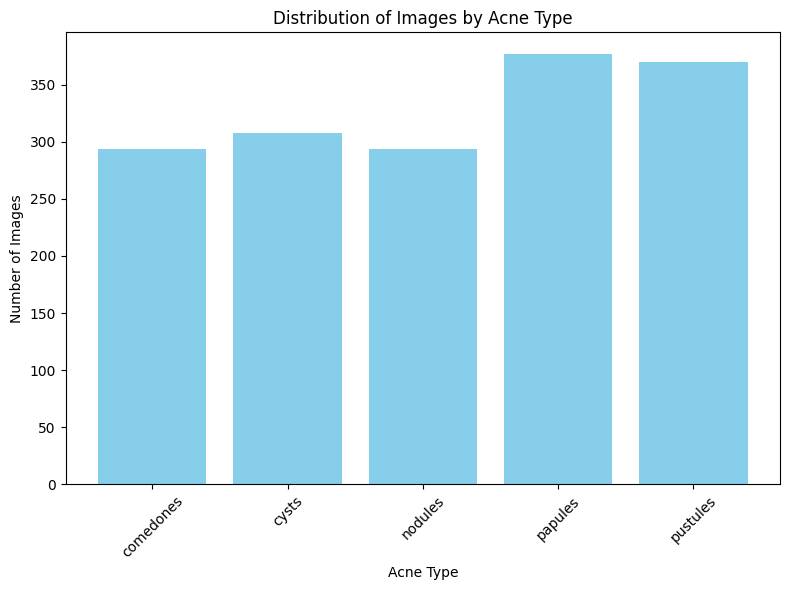

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'acne_image_multi_label/updated_image_labels.csv'
updated_image_labels_df = pd.read_csv(csv_file_path)

# Count the number of images for each label
label_counts = updated_image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

### ` 2. Pie Chart `

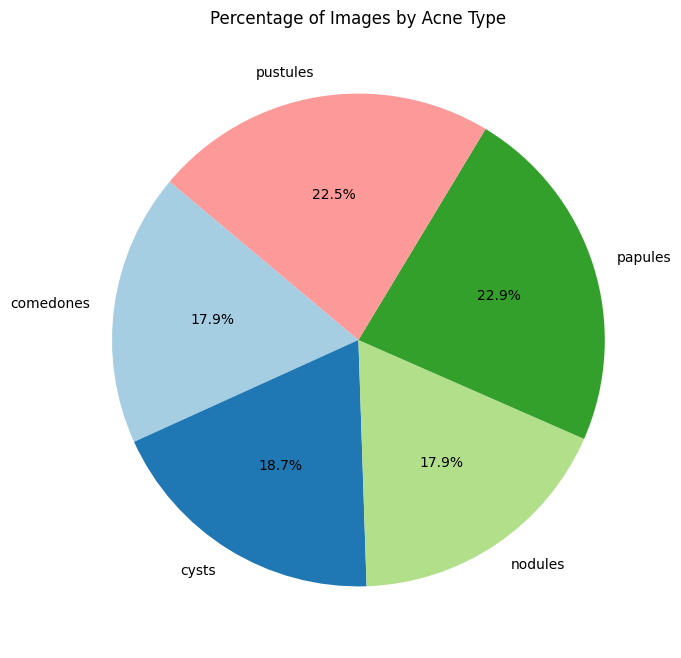

In [8]:
# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Images by Acne Type')
plt.show()

targets = np.array(image_labels_df.iloc[:, 1:])

In [9]:
updated_image_labels_df.shape

(1346, 6)

In [10]:
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import os

# Load the updated CSV file with augmented images
dataset_dir = 'acne_image_multi_label/'
updated_csv_file_path = os.path.join(dataset_dir, 'updated_image_labels.csv')
updated_image_labels_df = pd.read_csv(updated_csv_file_path)

# Extract features and multilabel targets
X = updated_image_labels_df.drop(columns=['comedones', 'cysts', 'nodules', 'papules', 'pustules']).values
y = updated_image_labels_df[['comedones', 'cysts', 'nodules', 'papules', 'pustules']].values

# Perform iterative stratified split for multilabel data
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.2)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

# Convert arrays back to DataFrames
train_df = pd.DataFrame(np.hstack((X_train, y_train)), columns=updated_image_labels_df.columns)
val_df = pd.DataFrame(np.hstack((X_val, y_val)), columns=updated_image_labels_df.columns)
test_df = pd.DataFrame(np.hstack((X_test, y_test)), columns=updated_image_labels_df.columns)

# Save the splits into separate CSV files
train_csv_path = os.path.join(dataset_dir, 'train_image_labels.csv')
val_csv_path = os.path.join(dataset_dir, 'val_image_labels.csv')
test_csv_path = os.path.join(dataset_dir, 'test_image_labels.csv')

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

# Print summary
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 1073
Validation set size: 134
Test set size: 139


In [11]:
train_df

,image_name,comedones,cysts,nodules,papules,pustules
0,2 (53)1 - Copy.jpg,1,0,0,0,0
1,34_jpeg_jpg.rf.0adac2e488226fb2f0f8b5758f839c6...,1,0,0,0,0
2,360_F_76033410_rJoKiNewoRuSzxXkALKr6bbYwl2U39D...,1,0,0,0,0
3,Acne (143).jpg,1,0,0,1,0
4,acne-black-spots-and-scars-on-forehead.jpg,1,0,0,0,0
...,...,...,...,...,...,...
1068,set2---30-_jpg.rf.fc8d373d20fba5997ee498e59872...,0,1,0,0,0
1069,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0
1070,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0
1071,shutterstock_2223729759_jpg.rf.15d340497bb97e2...,0,1,0,0,0


### Visualizing train dataset split

Label Counts:
 comedones    235
cysts        246
nodules      235
papules      302
pustules     296
dtype: int64


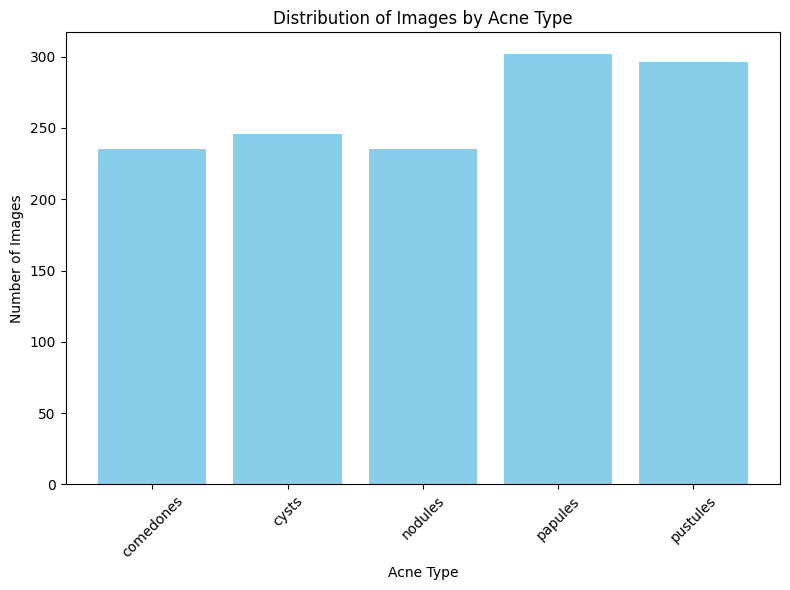

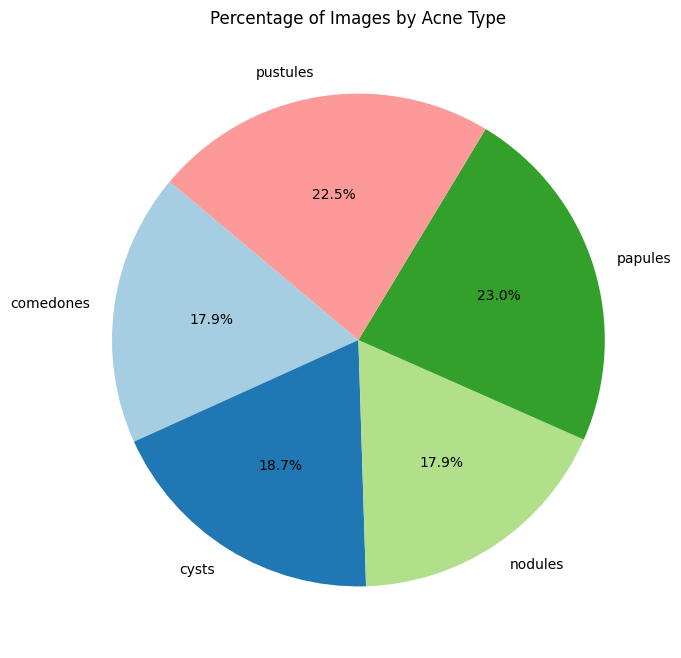

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
train_file_path = 'acne_image_multi_label/train_image_labels.csv'
train_image_labels_df = pd.read_csv(train_file_path)

# Count the number of images for each label
label_counts = train_image_labels_df.iloc[:, 1:].sum()

# Print the counts to verify
print("Label Counts:\n", label_counts)

# Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Acne Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Acne Type')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Images by Acne Type')
plt.show()

targets = np.array(image_labels_df.iloc[:, 1:])